In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt
from PIL import Image

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
from RegModels import GreenUnet160, GreenUnet160b, GreenUnet160c, GreenUnet320
from ImageProcessor import Merge, Split

### Training Phase

In [3]:
train_x = np.load('../Splitted_training_data/NIR2G_160_train_x.npy')
train_y = np.load('../Splitted_training_data/NIR2G_160_train_y.npy')

print('X.shape')
print(train_x.shape)
print('Y.shape')
print(train_y.shape)

X.shape
(4795, 160, 160, 1)
Y.shape
(4795, 160, 160, 1)


In [40]:
#model = GreenUnet160()
#model = GreenUnet160b()
model = GreenUnet160c()
#model = GreenUnet320()
model.model().summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 160, 160, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_76[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 160, 160, 32) 128         conv2d_77[0][0]                  
_______________________________________________________________________________________

In [29]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt)
history = model.fit(train_x, train_y, batch_size=32, epochs=25, validation_split=0.2, initial_epoch=0)

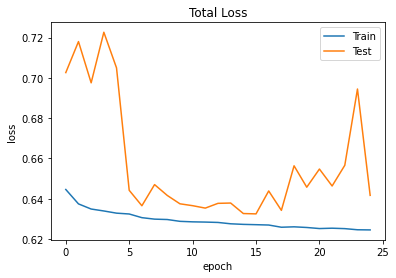

In [5]:
def plotLoss(titles, dataList):
    for data in dataList:
        plt.plot(data)
    plt.title('Total Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(titles)
    plt.show()
    
plotLoss(['Train', 'Test'], [history.history['loss'], history.history['val_loss']])

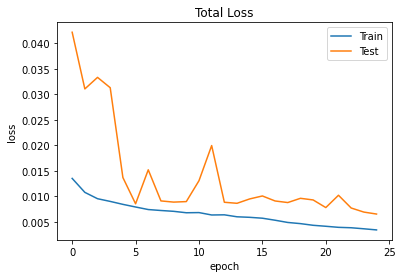

In [6]:
### Temporarily write losses to csv
import csv
def getTempLoss():
    with open('./outputs/losses.csv', 'r', newline='') as csvfile:
        data = list(csv.reader(csvfile))
        data = [
            [float(i) for i in data[0]],
            [float(i) for i in data[1]]
        ]
        return data
    
def newHistory(isNew, newList):
    content = []
    if isNew:
        content = newList
    else:
        oldLoss = getTempLoss()
        
        content = [
            oldLoss[0] + newList[0],
            oldLoss[1] + newList[1]
        ]
    with open('./outputs/losses.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(content)
    return content

content = newHistory(0, [history.history['loss'], history.history['val_loss']])
plotLoss(['Train', 'Test'], content)

#### Save weights

In [23]:
model.save_weights('./weights/GreenUnet160c_weights_202024Nov.h5')

### Trained Models

In [43]:
model.load_weights('./weights/GreenUnet160c_weights_202024Nov.h5')

(160, 160)


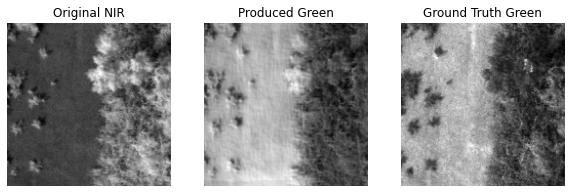

In [48]:
index = 15
img = train_x[index:index+1, :, :, :]
img_g = train_y[index, :, :, 0]
p = model.predict(img)
p = p.squeeze()
img = img.squeeze()
print(p.shape)

img_ls = [img, p, img_g]
title = ['Original NIR', 'Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,3))
for i in range(3):
    ax = fig.add_subplot(i+131)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')

### Predict Tiles & Merge 

(1280, 960)


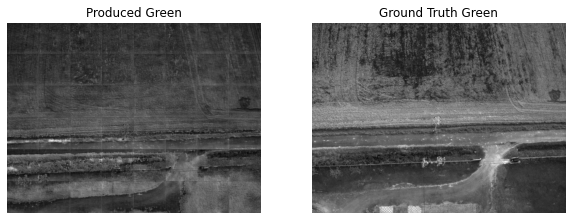

In [21]:
size = 160
index = int(960/size * 1280/size)
name = '0103'
NIR = cv2.imread('../UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
green = cv2.imread('../UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)

NIR = NIR/255
NIR_set = Split(NIR)
NIR_set = np.stack(NIR_set, axis=0)
NIR_set = np.expand_dims(NIR_set, axis=-1)
p = Merge(NIR_set, model.predict)
print(p.size)

img_ls = [p, green]
title = ['Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,6))
for i in range(2):
    ax = fig.add_subplot(i+121)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')
    
p.save('./outputs/produced_green.tif')

### Register

In [22]:
from SIFT_and_RANSAC import SIFT, matcher, getHomography

img1 = cv2.imread('../UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
dummy = cv2.imread('./outputs/produced_green.tif', cv2.IMREAD_GRAYSCALE)

kp1, des1 = SIFT(img1)
kp2, des2 = SIFT(dummy)
matches = matcher(des1, des2)
h = getHomography(matches, kp1, kp2)
print(h)

img = np.zeros((img1.shape[0], img1.shape[1], 3), dtype='uint8')
height, width, channels = img.shape

img[:, :, 0] = img1
img[:, :, 1] = 0 #cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_3toIMG_{name}_2_registered.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:, :, 2] = cv2.warpAffine(img2, h, (width, height))
cv2.imshow('Reg', img)
cv2.imwrite('./outputs/{}_Reg.tif'.format(name), img)

cv2.waitKey(0)
cv2.destroyAllWindows()

[[-1.83715113e-01 -4.90247029e-01  1.01018749e+03]
 [ 4.90247029e-01 -1.83715113e-01  1.45575791e+02]]
